# HTTP3 vs HTTP2 Test Results Visualization
Source: HAR files located under `data/`.

Usage:
```
show_results('data/folder_with_har_files')
```

DE (Nürnberg):
HTTP 3 median = 0.635
HTTP 2 median = 0.549
HTTP 3 mean = 0.6472105263157895
HTTP 2 mean = 0.86228
HTTP 3 fastest 90 percentile median = 0.6114999999999999
HTTP 2 fastest 90 percentile median = 0.533
HTTP 3 fastest 90 percentile mean = 0.6148235294117647
HTTP 2 fastest 90 percentile mean = 0.7364222222222223
HTTP 3 min = 0.482
HTTP 2 min = 0.42
HTTP 3 max = 1.263
HTTP 2 max = 2.199


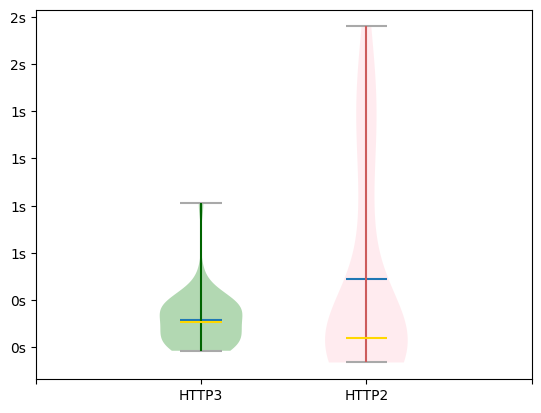

FI (Helsinki):
HTTP 3 median = 0.6465000000000001
HTTP 2 median = 0.695
HTTP 3 mean = 0.670225
HTTP 2 mean = 0.9317142857142858
HTTP 3 fastest 90 percentile median = 0.6425000000000001
HTTP 2 fastest 90 percentile median = 0.655
HTTP 3 fastest 90 percentile mean = 0.6488611111111111
HTTP 2 fastest 90 percentile mean = 0.7768863636363637
HTTP 3 min = 0.536
HTTP 2 min = 0.555
HTTP 3 max = 0.921
HTTP 2 max = 2.842


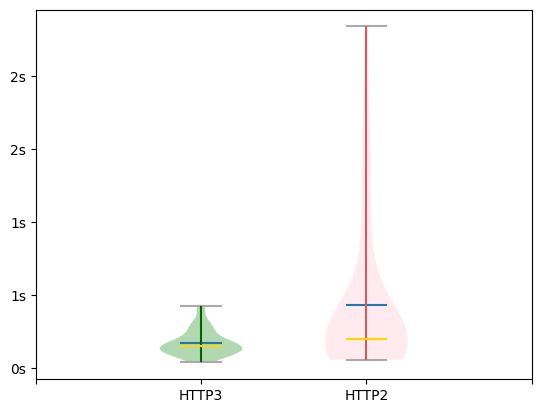

US (East Coast):
HTTP 3 median = 1.28
HTTP 2 median = 1.674
HTTP 3 mean = 1.3491224489795919
HTTP 2 mean = 1.7942291666666668
HTTP 3 fastest 90 percentile median = 1.2715
HTTP 2 fastest 90 percentile median = 1.635
HTTP 3 fastest 90 percentile mean = 1.3021590909090908
HTTP 2 fastest 90 percentile mean = 1.6609302325581397
HTTP 3 min = 1.143
HTTP 2 min = 1.284
HTTP 3 max = 2.173
HTTP 2 max = 4.871


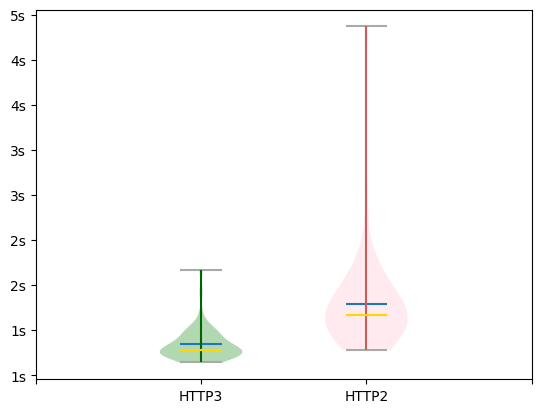

PL (fiber):
HTTP 3 median = 0.839
HTTP 2 median = 0.8154999999999999
HTTP 3 mean = 0.8856470588235293
HTTP 2 mean = 1.0117222222222222
HTTP 3 fastest 90 percentile median = 0.838
HTTP 2 fastest 90 percentile median = 0.8095
HTTP 3 fastest 90 percentile mean = 0.8409333333333333
HTTP 2 fastest 90 percentile mean = 0.874
HTTP 3 min = 0.753
HTTP 2 min = 0.727
HTTP 3 max = 1.428
HTTP 2 max = 2.904


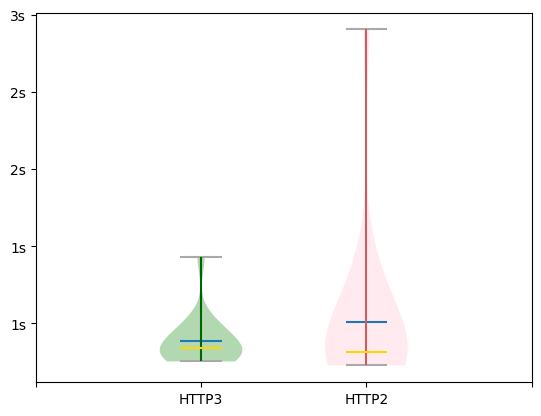

PL mobile LTE:
HTTP 3 median = 1.6019999999999999
HTTP 2 median = 1.2035
HTTP 3 mean = 1.7172142857142856
HTTP 2 mean = 1.3895
HTTP 3 fastest 90 percentile median = 1.585
HTTP 2 fastest 90 percentile median = 1.1815
HTTP 3 fastest 90 percentile mean = 1.5624166666666666
HTTP 2 fastest 90 percentile mean = 1.2130000000000003
HTTP 3 min = 1.235
HTTP 2 min = 0.896
HTTP 3 max = 2.723
HTTP 2 max = 3.431


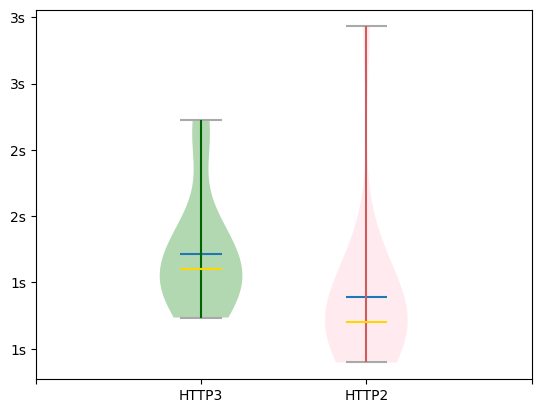

PL mobile poor quality ~15% packets loss:
HTTP 3 median = 6.0280000000000005
HTTP 2 median = 8.94
HTTP 3 mean = 6.685555555555556
HTTP 2 mean = 12.855411764705883
HTTP 3 fastest 90 percentile median = 5.807
HTTP 2 fastest 90 percentile median = 8.243
HTTP 3 fastest 90 percentile mean = 6.3260625
HTTP 2 fastest 90 percentile mean = 10.225866666666667
HTTP 3 min = 4.023
HTTP 2 min = 5.921
HTTP 3 max = 9.774
HTTP 2 max = 36.713


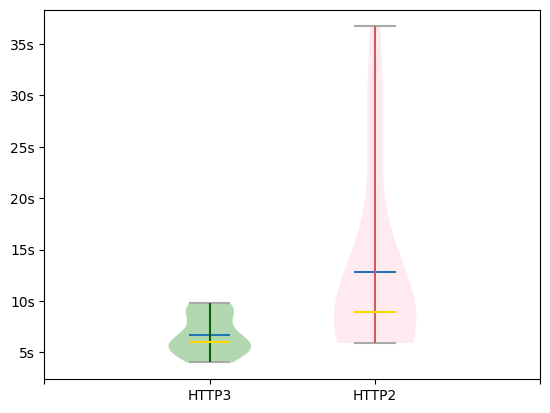

In [35]:
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
import datetime
import pytz
import collections


def json_from_file(path):
    f = open(path, "r")
    json_data = json.loads(f.read())
    return json_data


def to_timestamp(datetime_str):
    dt = datetime.datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%S.%fZ")
    dt = dt.replace(tzinfo=pytz.UTC)
    timestamp = dt.timestamp() * 1000
    return int(timestamp)


def summarize_response_time(json_data, include_script=True):
    """
    :param json_data: raw json data from a har file
    :param include_script: If set to False, it stops counting time
           on the first request initiated by a script, not to include in the total time
           async requests from third party scripts.
    :return: summed response time, number of requests analyzed
    """
    request_time = 0.0
    start_time = 0.0
    i = 0

    for entry in json_data['log']['entries']:
        if entry['startedDateTime']:
            if not include_script and str(entry['_initiator_type']) == 'script':
                break

            if start_time == 0: start_time = to_timestamp(str(entry['startedDateTime']))

            request_time = to_timestamp(str(entry['startedDateTime'])) + int(entry['time'])
            i += 1

    return (request_time - start_time) / 1000, i


def get_number_of_requests(json_data, include_script=True):
    i = 0

    for entry in json_data['log']['entries']:
        if entry['startedDateTime']:
            if not include_script and str(entry['_initiator_type']) == 'script':
                break
            i += 1

    return i


def get_results(results_list, index, include_script=True):
    x = []
    y = []
    number_of_requests = []

    for i, entry in enumerate(results_list):
        number_of_requests.append(get_number_of_requests(entry, include_script))

    counter = collections.Counter(number_of_requests)
    most_common = counter.most_common(1)

    for i, entry in enumerate(results_list):
        summary, requests_count = summarize_response_time(entry, include_script)

        # Filter out tests with not matching number of requests.
        if requests_count == most_common[0][0]:
            x.append(index)
            y.append(summary)

    return x, y


def get_lowest_values(results, percentile):
    sorted_results = np.sort(results)
    index = int(len(sorted_results) * percentile / 100)
    lowest_values = sorted_results[:index]
    return lowest_values


def show_results(path, include_script=True):
    http3_list = []
    http2_list = []

    for file in glob.glob(path + '/http3/*.har'):
        data = json_from_file(file)
        http3_list.append(data)

    for file in glob.glob(path + '/http2/*.har'):
        data = json_from_file(file)
        http2_list.append(data)

    http3_x, http3_y = get_results(http3_list, 1, include_script)
    http2_x, http2_y = get_results(http2_list, 2, include_script)

    print('HTTP 3 median = ' + str(np.median(http3_y)))
    print('HTTP 2 median = ' + str(np.median(http2_y)))
    print('HTTP 3 mean = ' + str(np.mean(http3_y)))
    print('HTTP 2 mean = ' + str(np.mean(http2_y)))
    print('HTTP 3 fastest 90 percentile median = ' + str(np.median(get_lowest_values(http3_y, 90))))
    print('HTTP 2 fastest 90 percentile median = ' + str(np.median(get_lowest_values(http2_y, 90))))
    print('HTTP 3 fastest 90 percentile mean = ' + str(np.mean(get_lowest_values(http3_y, 90))))
    print('HTTP 2 fastest 90 percentile mean = ' + str(np.mean(get_lowest_values(http2_y, 90))))
    print('HTTP 3 min = ' + str(np.min(http3_y)))
    print('HTTP 2 min = ' + str(np.min(http2_y)))
    print('HTTP 3 max = ' + str(np.max(http3_y)))
    print('HTTP 2 max = ' + str(np.max(http2_y)))
    plot = plt.violinplot([http3_y, http2_y], showmedians=True, showmeans=True)
    plt.xticks(range(0, 4), ['', 'HTTP3', 'HTTP2', ''])
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%ds'))

    bgcolors = ['green', 'pink']
    mediancolors = ['gold', 'gold']
    barcolors = ['darkgreen', 'indianred']
    extremescolors = ['darkgray', 'darkgray']

    for patch, color in zip(plot['bodies'], bgcolors):
        patch.set_facecolor(color)
        patch.set_edgecolor(None)

    plot['cmedians'].set_colors(mediancolors)
    plot['cmins'].set_colors(extremescolors)
    plot['cmaxes'].set_colors(extremescolors)
    plot['cbars'].set_colors(barcolors)

    plt.show()


print("DE (Nürnberg):")
show_results('data/de', False)
print("FI (Helsinki):")
show_results('data/fi', False)
print("US (East Coast):")
show_results('data/us', False)
print("PL (fiber):")
show_results('data/pl-fiber', False)
print("PL mobile LTE:")
show_results('data/pl-mobile', False)
print("PL mobile poor quality ~15% packets loss:")
show_results('data/pl-mobile3g', False)